# Import Modules

In [46]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

# 数据读取

In [8]:
S_sentinel_bands = glob("../Data/sundarbans_data/*B?*.tiff")
S_sentinel_bands.sort()
S_sentinel_bands

['../Data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '../Data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '../Data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '../Data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '../Data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '../Data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '../Data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '../Data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '../Data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '../Data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 '../Data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B12_(

In [10]:
l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))

In [11]:
arr_st = np.stack(l)
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 954
Width: 298
Bands: 12


# 可视化

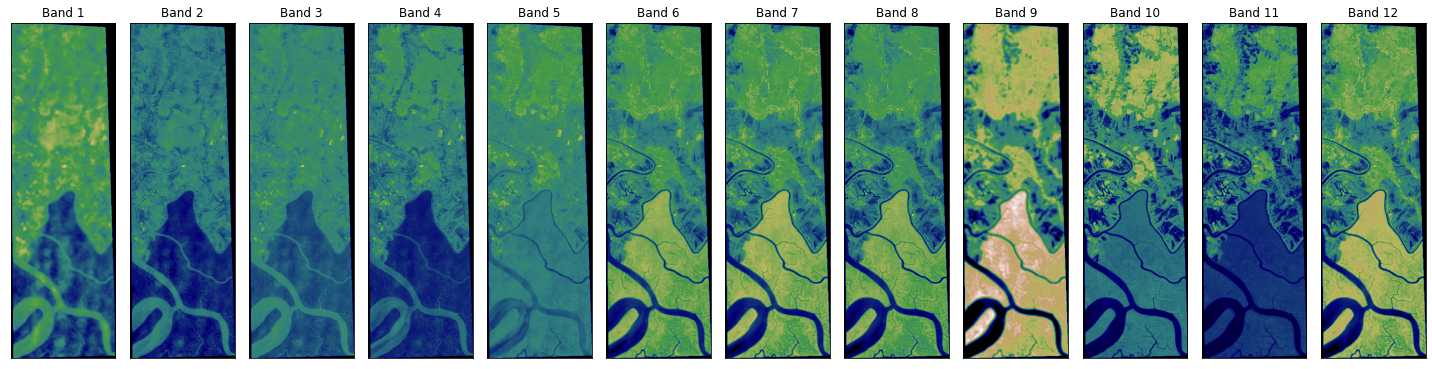

In [47]:
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (20, 12), cols = 12, cbar = False)

plt.show()

# 真彩RGB

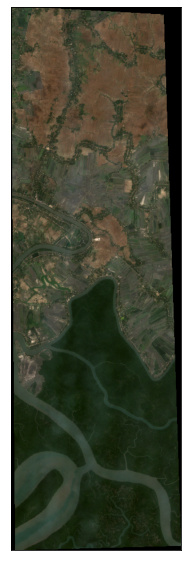

In [48]:
rgb = ep.plot_rgb(arr_st, 
                  rgb=(3,2,1), 
                  figsize=(8, 10), 
                  # title='RGB Composite Image'
                  )

plt.show()

# 真彩RGB+2%拉伸

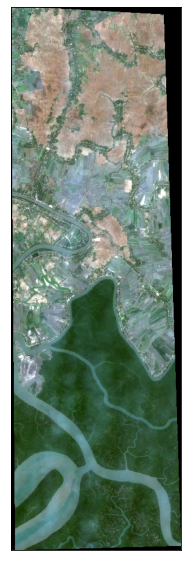

In [49]:
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

# 直方图分布

In [52]:
arr_st[0]

array([[4954, 4863, 4797, ...,    0,    0,    0],
       [5020, 4941, 4882, ...,    0,    0,    0],
       [5046, 4974, 4922, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint16)

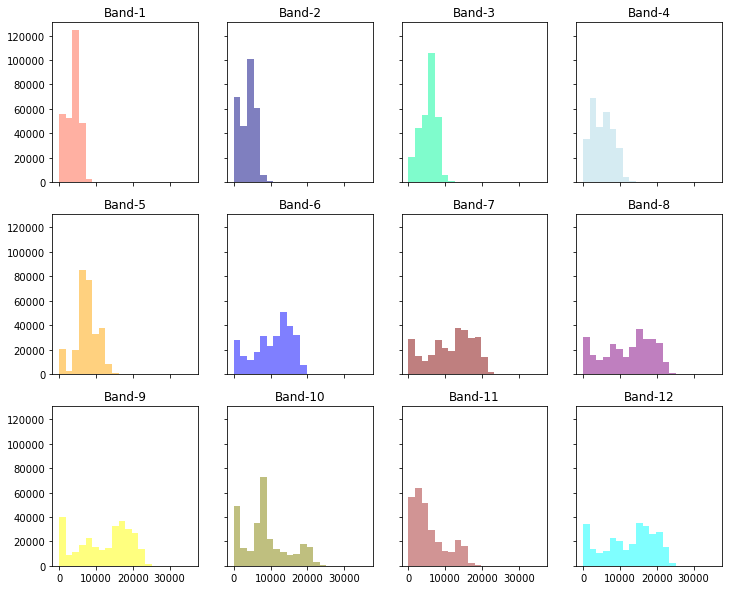

In [56]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

ep.hist(arr_st, 
        colors = colors,
        title=[f'Band-{i}' for i in range(1, 13)], 
        cols=4, 
        alpha=0.5, 
        figsize = (12, 10),
        )

plt.show()

# 分类处理

In [20]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(954, 298, 12)

## 标准化

In [21]:
from sklearn.preprocessing import StandardScaler

X_data = x.reshape(-1, 12)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(284292, 12)

In [29]:
y_data = loadmat('../Data/sundarbans_data/Sundarbands_gt.mat')['gt']
y_data.shape

(954, 298)

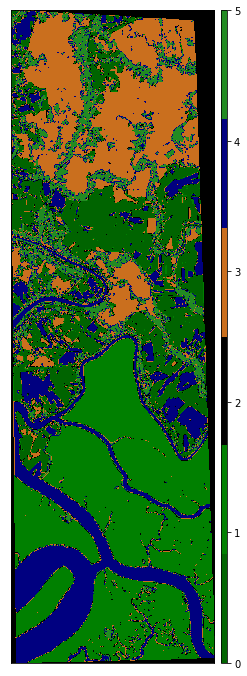

In [31]:
# Visualize Groundtruth
ep.plot_bands(y_data, cmap=ListedColormap(['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

# 训练和检验数据集

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data.ravel(), test_size=0.30, stratify = y_data.ravel())

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (199004, 12)
X_test Shape: (85288, 12)
y_train Shape: (199004,)
y_test Shape:(85288,)


## K-Nearest Neighbor Classifier (K-NNC)

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

In [36]:
print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}")

Accuracy: 98.86033205140231


In [37]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     16222
           1       1.00      1.00      1.00     23570
           2       1.00      1.00      1.00      6095
           3       0.99      0.99      0.99     16790
           4       0.99      0.98      0.99     13545
           5       0.98      0.95      0.97      9066

    accuracy                           0.99     85288
   macro avg       0.99      0.99      0.99     85288
weighted avg       0.99      0.99      0.99     85288



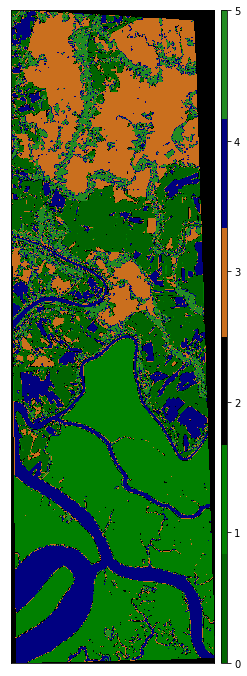

In [38]:
# Visualize Classification Map of K-NNC

ep.plot_bands(knn.predict(X_scaled).reshape((954, 298)), 
              cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                   '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

## Support Vector Machine (SVM)

In [39]:
from sklearn.svm import SVC

svm = SVC(C=3.0, kernel='rbf', degree=6, cache_size=1024)
svm.fit(X_train, y_train)

SVC(C=3.0, cache_size=1024, degree=6)

In [40]:
svm_pred = svm.predict(X_test)

In [41]:
print(f"Accuracy: {accuracy_score(y_test, svm_pred)*100}")

Accuracy: 99.86633524059657


In [42]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16222
           1       1.00      1.00      1.00     23570
           2       1.00      1.00      1.00      6095
           3       1.00      1.00      1.00     16790
           4       1.00      1.00      1.00     13545
           5       1.00      1.00      1.00      9066

    accuracy                           1.00     85288
   macro avg       1.00      1.00      1.00     85288
weighted avg       1.00      1.00      1.00     85288



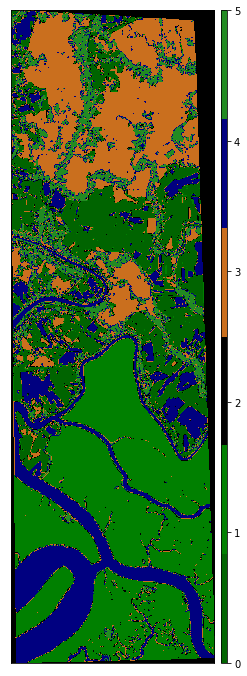

In [43]:
# Visualize Classification Map of SVM

ep.plot_bands(svm.predict(X_scaled).reshape((954, 298)), 
              cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                   '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

# Light BGM

In [1]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)

params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=15
params['num_class']=6 #no.of unique values in the target class not inclusive of the end value

clf = lgb.train(params, d_train, 100)

ModuleNotFoundError: No module named 'lightgbm'

In [4]:
! pip install lightgbm

     |██▋                             | 122 kB 85 kB/s eta 0:00:17ERROR: Exception:
Traceback (most recent call last):
  File "/Users/luoyp/Software/miniconda3/envs/py_env/lib/python3.8/site-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/Users/luoyp/Software/miniconda3/envs/py_env/lib/python3.8/site-packages/pip/_vendor/urllib3/response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/Users/luoyp/Software/miniconda3/envs/py_env/lib/python3.8/site-packages/pip/_vendor/cachecontrol/filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "/Users/luoyp/Software/miniconda3/envs/py_env/lib/python3.8/http/client.py", line 459, in read
    n = self.readinto(b)
  File "/Users/luoyp/Software/miniconda3/envs/py_env/lib/python3.8/http/client.py", line 503, in readinto
    n = self.fp.readinto(b)
  File "/Users/luoyp/Software/miniconda3/envs/py_env/lib/python3.8/socket.py", line 669, in readinto
    re